In [2]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def buildTrain(train, pastDay=1, futureDay=1):
    X_train, Y_train ,Z_train= [], [],[]
    for i in range(train.shape[0]-futureDay-pastDay+1):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["high"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay+futureDay-1]["high"]))
    return np.array(X_train), np.array(Y_train), np.array(Z_train)
def shuffle(X,Y,Z):
    np.random.seed()
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList],Z[randomList]
def splitData(X,Y,Z,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    Z_val = Z[:int(Z.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val,Z_val

In [23]:
train = pd.read_csv(r"C:\Users\admin\Desktop\Project\data\台北一\蔬果\奇異果-進口.csv")
train=train.drop(["Unnamed: 0"], axis=1)
train=train.drop(["crop_name"], axis=1)
train=train.drop(["crop_num"], axis=1)
train=train.drop(["market_name"], axis=1)
train=train.drop(["market_num"], axis=1)
temp=train
train= train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
train_x1,train_y1,train_z1=buildTrain(train)
train_x2,train_y2,train_z2=buildTrain(temp)
train_x,train_y,train_z=train_x1,train_y2,train_z2
train_x,train_y,train_z= shuffle(train_x,train_y,train_z)
train_x,train_y, val_x, val_y ,val_z= splitData(train_x,train_y,train_z, 0.05)

In [24]:
model = Sequential()
model.add(LSTM(200, input_length=train_x.shape[1],input_dim= train_x.shape[2],return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(150))
model.add(Dropout(0.6))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x,train_y, epochs=300, batch_size=32, validation_split=0.1, callbacks=[callback])

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, input_shape=(1, 9), return_sequences=True)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 1, 200)            168000    
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 200)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 150)               210600    
_________________________________________________________________
dropout_18 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 151       
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 378,751
Trainable params: 378,751
Non-trainable params: 0
_________________________________________________________________
Trai

Epoch 64/300
1828/1828 [==============================] - 0s 237us/step - loss: 976.2536 - val_loss: 1304.4350
Epoch 65/300
1828/1828 [==============================] - 0s 241us/step - loss: 960.6921 - val_loss: 1301.5732
Epoch 66/300
1828/1828 [==============================] - 0s 240us/step - loss: 980.9114 - val_loss: 1301.1075
Epoch 67/300
1828/1828 [==============================] - 0s 239us/step - loss: 948.4139 - val_loss: 1298.2815
Epoch 68/300
1828/1828 [==============================] - 0s 239us/step - loss: 970.3021 - val_loss: 1301.3576
Epoch 69/300
1828/1828 [==============================] - 0s 238us/step - loss: 986.2655 - val_loss: 1300.9230
Epoch 70/300
1828/1828 [==============================] - 0s 233us/step - loss: 964.8102 - val_loss: 1297.5860
Epoch 71/300
1828/1828 [==============================] - 0s 234us/step - loss: 978.8824 - val_loss: 1298.8453
Epoch 72/300
1828/1828 [==============================] - 0s 238us/step - loss: 990.7259 - val_loss: 1297.2466
E

accuracy:59.43396226415094%


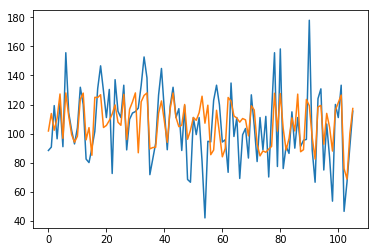

In [25]:
a=range(0,val_y.shape[0])
val_y=val_y.reshape(-1)
val_z=val_z.reshape(-1)
plt.plot(a,val_y)
b=[]
co=0
for i in range(0,val_x.shape[0]):
    temp=val_x[i]
    temp=temp.reshape(1,1,9)
    z=model.predict(temp, verbose=0)
    if val_y[i]>=val_z[i] and z>=val_z[i]:
        co=co+1
    if val_y[i]<val_z[i] and z<val_z[i]:
        co=co+1
    b.append(z)
b=np.array(b)
b=b.reshape(-1)
plt.plot(a,b)
acc=100*(co/val_x.shape[0])
print("accuracy:"+str(acc)+"%")
plt.show()

In [ ]:
model = Sequential()
model.add(LSTM(64, input_length=train_x.shape[1],input_dim= train_x.shape[2],return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x,train_y, epochs=300, batch_size=8, validation_split=0.1, callbacks=[callback])

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, input_shape=(1, 9))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 64)             18944     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 31,393
Trainable params: 31,393
Non-trainable params: 0
_________________________________________________________________
Train 

accuracy:63.84976525821596%


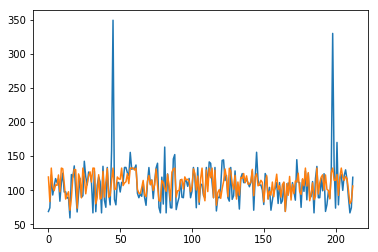

In [5]:
a=range(0,val_y.shape[0])
val_y=val_y.reshape(-1)
val_z=val_z.reshape(-1)
plt.plot(a,val_y)
b=[]
co=0
for i in range(0,val_x.shape[0]):
    temp=val_x[i]
    temp=temp.reshape(1,1,9)
    z=model.predict(temp, verbose=0)
    if val_y[i]>=val_z[i] and z>=val_z[i]:
        co=co+1
    if val_y[i]<val_z[i] and z<val_z[i]:
        co=co+1
    b.append(z)
b=np.array(b)
b=b.reshape(-1)
plt.plot(a,b)
acc=100*(co/val_x.shape[0])
print("accuracy:"+str(acc)+"%")
plt.show()

In [ ]:
model = Sequential()
model.add(LSTM(200, input_length=train_x.shape[1],input_dim= train_x.shape[2],return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x,train_y, epochs=300, batch_size=16, validation_split=0.1, callbacks=[callback])

In [ ]:
a=range(0,val_y.shape[0])
val_y=val_y.reshape(-1)
val_z=val_z.reshape(-1)
plt.plot(a,val_y)
b=[]
co=0
for i in range(0,val_x.shape[0]):
    temp=val_x[i]
    temp=temp.reshape(1,1,9)
    z=model.predict(temp, verbose=0)
    if val_y[i]>=val_z[i] and z>=val_z[i]:
        co=co+1
    if val_y[i]<val_z[i] and z<val_z[i]:
        co=co+1
    b.append(z)
b=np.array(b)
b=b.reshape(-1)
plt.plot(a,b)
acc=100*(co/val_x.shape[0])
print("accuracy:"+str(acc)+"%")
plt.show()